In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

import cv2
import itertools
import pathlib
import warnings
from PIL import Image
from random import randint

warnings.filterwarnings('ignore')

#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix


from tensorflow import keras
from keras import layers
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from distutils.dir_util import copy_tree, remove_tree

import os
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np

In [4]:
import glob
def create_data(data_dir):
    image_paths = []
    mask_paths = []
    classes = sorted(os.listdir(data_dir))
    
    single_mask_paths = sorted([sorted(glob.glob(data_dir + name + "/*mask.png")) for name in classes])
    double_mask_paths = sorted([sorted(glob.glob(data_dir + name + "/*mask_1.png")) for name in classes])
    
    for class_path in single_mask_paths:
        for path in class_path:
            img_path = path.replace('_mask', '')
            image_paths.append(img_path)
            mask_paths.append(path)
    
    return image_paths, mask_paths

In [13]:
data_dir = "D:\\project\\Dataset_BUSI_with_GT\\"
image_paths, mask_paths = create_data(data_dir)

In [19]:
for i in image_paths:
    #dst_path = r"E:\pynative\account\sales.txt"
    shutil.move(i, "D:\\project\\data")

In [21]:
import splitfolders
splitfolders.ratio("D:\\project\\dataset", output="breast data set", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 780 files [00:31, 24.79 files/s]


In [22]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./breast data set/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./breast data set/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./breast data set/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)


Found 623 files belonging to 3 classes.
Found 80 files belonging to 3 classes.
Found 77 files belonging to 3 classes.


In [23]:
class_name=train_ds.class_names
class_name

['bengin', 'maligant', 'normal']

In [24]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

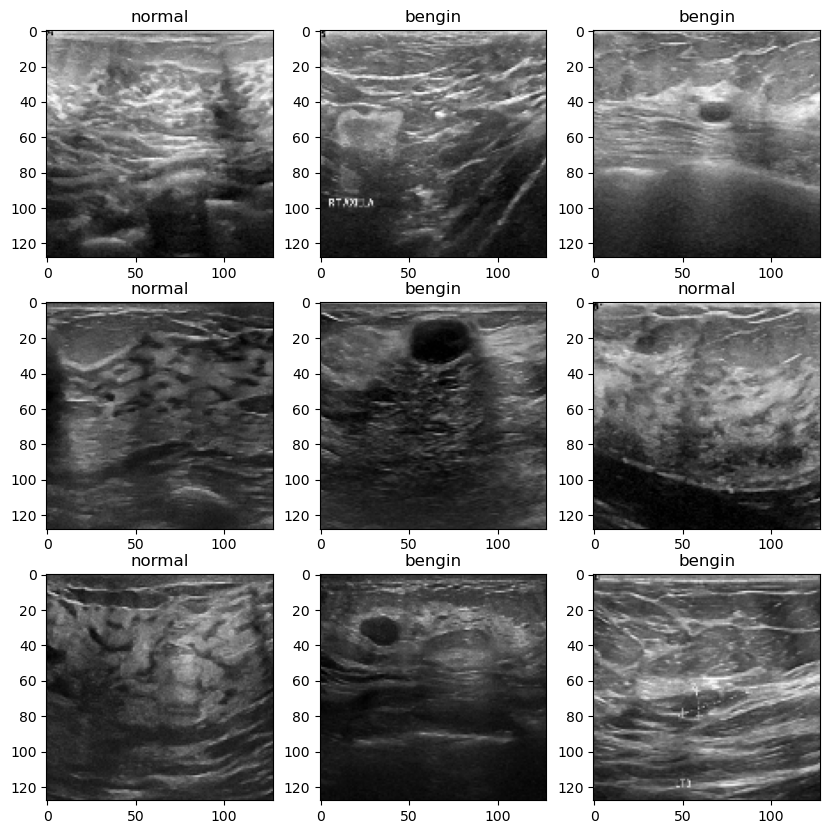

In [25]:
plt.figure(figsize=(10,10))
for image,label in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_name[label[i]])

In [26]:
data_dir='breast data set'

In [27]:
os.listdir(data_dir)

['test', 'train', 'val']

In [30]:
import os
len(os.listdir(os.path.join('breast data set','train','bengin')))

349

<function matplotlib.pyplot.show(close=None, block=None)>

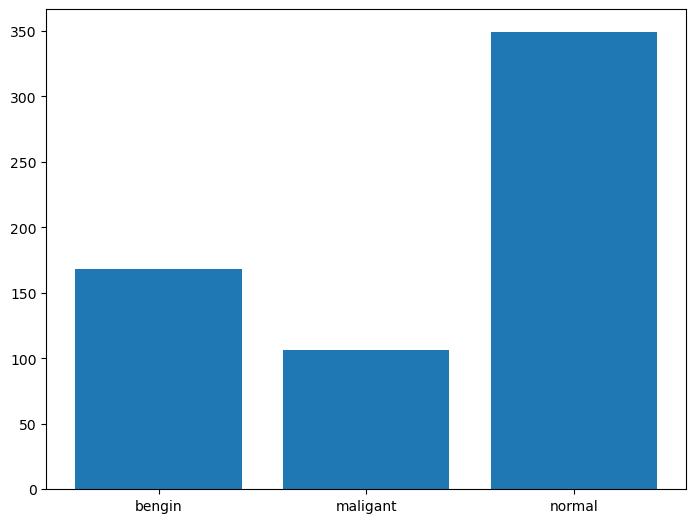

In [31]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [len(os.listdir(os.path.join('breast data set','train','maligant'))),
        len(os.listdir(os.path.join('breast data set','train','normal'))),
        len(os.listdir(os.path.join('breast data set','train','bengin')))]
ax.bar(class_name,size)
plt.show

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))

model.add(keras.layers.Dense(64,"relu"))

model.add(keras.layers.Dense(4,"softmax"))

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0

In [35]:
hist = model.fit(train_ds,validation_data=val_ds,epochs=30, batch_size=64, verbose=1)

Epoch 1/30
10/10 [==============================] - 11s 689ms/step - loss: 3.4798 - accuracy: 0.4880 - val_loss: 1.0195 - val_accuracy: 0.5584
Epoch 2/30
10/10 [==============================] - 7s 508ms/step - loss: 1.0927 - accuracy: 0.4077 - val_loss: 1.1571 - val_accuracy: 0.5584
Epoch 3/30
10/10 [==============================] - 6s 451ms/step - loss: 0.9782 - accuracy: 0.5602 - val_loss: 1.1418 - val_accuracy: 0.5584
Epoch 4/30
10/10 [==============================] - 5s 423ms/step - loss: 0.9511 - accuracy: 0.5602 - val_loss: 1.0110 - val_accuracy: 0.5584
Epoch 5/30
10/10 [==============================] - 6s 456ms/step - loss: 0.9077 - accuracy: 0.5602 - val_loss: 0.9956 - val_accuracy: 0.6234
Epoch 6/30
10/10 [==============================] - 6s 506ms/step - loss: 0.8575 - accuracy: 0.6260 - val_loss: 0.8663 - val_accuracy: 0.6753
Epoch 7/30
10/10 [==============================] - 6s 456ms/step - loss: 0.8492 - accuracy: 0.6404 - val_loss: 0.8675 - val_accuracy: 0.6883
Epoch

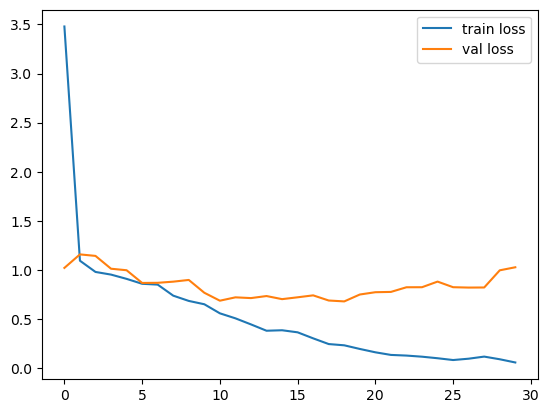

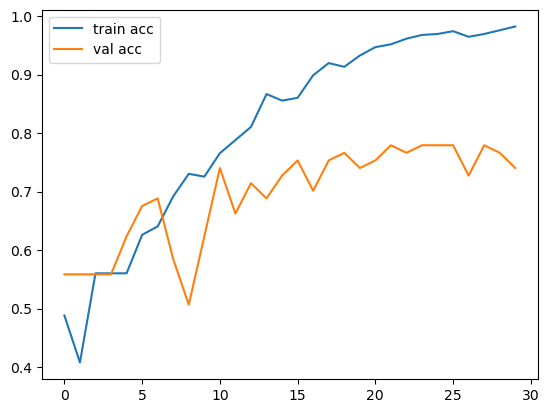

<Figure size 640x480 with 0 Axes>

In [36]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [37]:

from tensorflow.keras.models import load_model

model.save('breast_CNN_model.h5')

In [ ]:
#Vgg19 model

In [109]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     


train_ds_vgg = image_generator.flow_from_directory(batch_size=8,
                                                 directory="./breast data set/train",
                                                 shuffle=True,
                                                 target_size=(128,228), 
                                                 subset="training",
                                                 class_mode='categorical')

val_ds_vgg = image_generator.flow_from_directory(batch_size=8,
                                                 directory="./breast data set/test",
                                                 shuffle=True,
                                                 target_size=(176,208), 
                                                 subset="validation",
                                                 class_mode='categorical')

Found 500 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [117]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(input_shape=(128,128,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(3, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [120]:
modelvgg.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

In [122]:

hist = modelvgg.fit(train_ds,validation_data=val_ds,epochs=20, batch_size=64, verbose=1)

Epoch 1/20
10/10 [==============================] - 114s 11s/step - loss: 0.7115 - accuracy: 0.8363 - val_loss: 2.3211 - val_accuracy: 0.7013
Epoch 2/20
10/10 [==============================] - 101s 10s/step - loss: 0.3382 - accuracy: 0.8941 - val_loss: 1.8524 - val_accuracy: 0.6753
Epoch 3/20
10/10 [==============================] - 119s 12s/step - loss: 0.1595 - accuracy: 0.9390 - val_loss: 1.8913 - val_accuracy: 0.7143
Epoch 4/20
10/10 [==============================] - 118s 12s/step - loss: 0.0926 - accuracy: 0.9631 - val_loss: 1.9264 - val_accuracy: 0.7013
Epoch 5/20
10/10 [==============================] - 86s 8s/step - loss: 0.0340 - accuracy: 0.9839 - val_loss: 1.8234 - val_accuracy: 0.7532
Epoch 6/20
10/10 [==============================] - 86s 9s/step - loss: 0.0198 - accuracy: 0.9936 - val_loss: 1.8698 - val_accuracy: 0.7532
Epoch 7/20
10/10 [==============================] - 89s 9s/step - loss: 0.0363 - accuracy: 0.9904 - val_loss: 1.8370 - val_accuracy: 0.7403
Epoch 8/20
1

In [136]:
from tensorflow.keras.models import load_model

modelvgg.save('breast_VGG_model.h5')

In [ ]:
#Densenet model

In [123]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [124]:
training_set = train_datagen.flow_from_directory("./breast data set/train",
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

Found 623 images belonging to 3 classes.


In [125]:
test_set = test_datagen.flow_from_directory("./breast data set/test",
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 80 images belonging to 3 classes.


In [126]:
from tensorflow.keras.applications.densenet import DenseNet121
base_model = DenseNet121(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

In [128]:
for layer in base_model.layers:
    layer.trainable=False

In [129]:
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(3,activation='softmax'))

In [130]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 dropout_27 (Dropout)        (None, 7, 7, 1024)        0         
                                                                 
 flatten_13 (Flatten)        (None, 50176)             0         
                                                                 
 batch_normalization_30 (Bat  (None, 50176)            200704    
 chNormalization)                                                
                                                                 
 dense_40 (Dense)            (None, 64)                3211328   
                                                                 
 batch_normalization_31 (Bat  (None, 64)               256       
 chNormalization)                                     

In [131]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [133]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  batch_size=64,  
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
10/10 [==============================] - 74s 6s/step - loss: 1.1703 - accuracy: 0.4013 - val_loss: 2.5676 - val_accuracy: 0.5625
Epoch 2/10
10/10 [==============================] - 63s 6s/step - loss: 1.0998 - accuracy: 0.4398 - val_loss: 1.9104 - val_accuracy: 0.5625
Epoch 3/10
10/10 [==============================] - 91s 9s/step - loss: 1.0997 - accuracy: 0.4799 - val_loss: 1.4818 - val_accuracy: 0.5625
Epoch 4/10
10/10 [==============================] - 75s 7s/step - loss: 1.0498 - accuracy: 0.4751 - val_loss: 1.2341 - val_accuracy: 0.5625
Epoch 5/10
10/10 [==============================] - 81s 7s/step - loss: 1.0212 - accuracy: 0.5185 - val_loss: 1.0814 - val_accuracy: 0.5625
Epoch 6/10
10/10 [==============================] - 66s 6s/step - loss: 0.9863 - accuracy: 0.5329 - val_loss: 0.9564 - val_accuracy: 0.5625
Epoch 7/10
10/10 [==============================] - 72s 6s/step - loss: 1.0113 - accuracy: 0.5169 - val_loss: 0.8921 - val_accuracy: 0.5625
Epoch 8/10
10/10 [==

In [135]:
from tensorflow.keras.models import load_model

model.save('breast_densnet_model.h5')